In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import nbinom, norm, poisson, rv_continuous

from deep_uncertainty.evaluation.calibration import compute_continuous_ece
from deep_uncertainty.random_variables import DoublePoisson

## Helper Functions

In [2]:
def plot_posterior_predictive(
    x: np.ndarray,
    y: np.ndarray,
    mu: np.ndarray,
    upper: np.ndarray,
    lower: np.ndarray,
    error_color: str = "r",
    error_alpha: float = 0.2,
    show: bool = True,
    title: str = "",
    ax: plt.Axes | None = None,
):
    """Visualize a model's posterior predictive distribution over a 1d dataset (`x`, `y` both scalars) by showing the expected value and error bounds across the regression targets.

    Args:
        x (np.ndarray): The x values (inputs).
        y (np.ndarray): The ground truth y values (outputs).
        mu (np.ndarray): The expected values of the model's posterior predictive distribution over `y`.
        upper (np.ndarray): Upper bounds for the model's posterior predictive distribution over `y`.
        lower (np.ndarray): Lower bounds for the model's posterior predictive distribution over `y`.
        error_color (str, optional): Color with which to fill the model's error bounds. Defaults to "r".
        alpha (float, optional): Transparency value for the model's error bounds. Defaults to 0.2.
        show (bool, optional): Whether/not to show the resultant plot. Defaults to True.
        title (str, optional): If specified, a title for the resultant plot. Defaults to "".
        ax (plt.Axes | None, optional): If given, the axis on which to plot the posterior predictive distribution. Defaults to None (axis is created).
    """
    order = x.argsort()

    ax = plt.subplots(1, 1, figsize=(10, 6))[1] if ax is None else ax

    ax.scatter(x[order], y[order], alpha=0.1, label="Test Data", s=3)
    ax.plot(x[order], mu[order])
    ax.fill_between(
        x[order], lower[order], upper[order], color=error_color, alpha=error_alpha, label="95% CI"
    )
    ax.set_title(title)
    ax.set_ylim(y.min() - 5, y.max() + 5)
    ax.set_xticks([])
    ax.set_yticks([])
    if show:
        plt.show()

In [3]:
def plot_regression_calibration_curve_cdf(
    y_true: np.ndarray,
    posterior_predictive: rv_continuous,
    num_bins: int = 9,
    ax: plt.Axes | None = None,
    show: bool = True,
):
    """Given targets and a probabilistic regression model (represented as a continuous random variable over the targets), plot a calibration curve.

    Args:
        y_true (ndarray, (n,)): The true values of the regression targets.
        posterior_predictive (rv_continuous): Random variable representing the posterior predictive distribution over the targets.
        num_bins (int): Specifies how many probability thresholds to use for checking CDF calibration. This
                        corresponds to how many points will be plotted to form the calibration curve.
        ax (plt.Axes | None): The axis to plot on (if provided). If None is passed in, an axis is created.
        show (bool): Specifies whether/not to display the resultant plot.
    """
    epsilon = 1e-4
    p_vals = np.linspace(0 + epsilon, 1 - epsilon, num=num_bins).reshape(-1, 1)
    expected_pct_where_cdf_less_than_p = p_vals
    actual_pct_where_cdf_less_than_p = (posterior_predictive.cdf(y_true) <= p_vals).mean(axis=1)

    ece = compute_continuous_ece(y_true, posterior_predictive, num_bins=50, weights="frequency", alpha=2)

    ax = plt.subplots(1, 1)[1] if ax is None else ax
    ax.plot(
        expected_pct_where_cdf_less_than_p,
        expected_pct_where_cdf_less_than_p,
        linestyle="--",
        color="red",
        label="Perfectly calibrated",
    )
    ax.plot(
        expected_pct_where_cdf_less_than_p,
        actual_pct_where_cdf_less_than_p,
        marker="o",
        linestyle="-",
        color="black",
        label="Model",
        markersize=3,
    )
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.annotate(f"ECE: {ece:2f}", xy=(-0.05, 0.9), fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if show:
        plt.show()

## Data Generation

In [4]:
num_samples = 10000
cont_x = np.random.uniform(1, 10, size=num_samples)
mean = cont_x
variance = cont_x
gaussian_y = norm.rvs(loc=mean, scale=np.sqrt(variance))
poisson_y = poisson.rvs(mu=mean)
double_poisson_y = DoublePoisson(mean, 1).rvs((1, num_samples)).flatten()
eps = 1e-1
nbinom_y = nbinom.rvs(n=(mean**2 / (variance + eps - mean)).round(), p=(mean / (variance + eps)))

## Create Calibrated/Miscalibrated Posterior Pred. Dists

In [5]:
bad_mean = cont_x + 10
bad_variance = cont_x + 10

mu_hat = mean
gaussian_post_pred = norm(loc=mean, scale=np.sqrt(variance))
bad_gaussian_post_pred = norm(loc=bad_mean, scale=np.sqrt(bad_variance))

lambda_hat = mean
poisson_post_pred = poisson(mu=mean)
bad_poisson_post_pred = poisson(mu=bad_mean)

dpo_mu_hat = mean
dpo_post_pred = DoublePoisson(mean, mean/variance)
bad_dpo_post_pred = DoublePoisson(bad_mean, bad_mean / bad_variance)

nbinom_mu_hat = mean
nbinom_post_pred = nbinom(n=(mean**2 / (variance + eps - mean)).round(), p=(mean / (variance + eps)))
bad_nbinom_post_pred = nbinom(n=(bad_mean**2 / (bad_variance + eps - bad_mean)).round(), p=(bad_mean / (bad_variance + eps)))

## Produce Figure

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_11063/1349927967.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_11063/2730186373.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


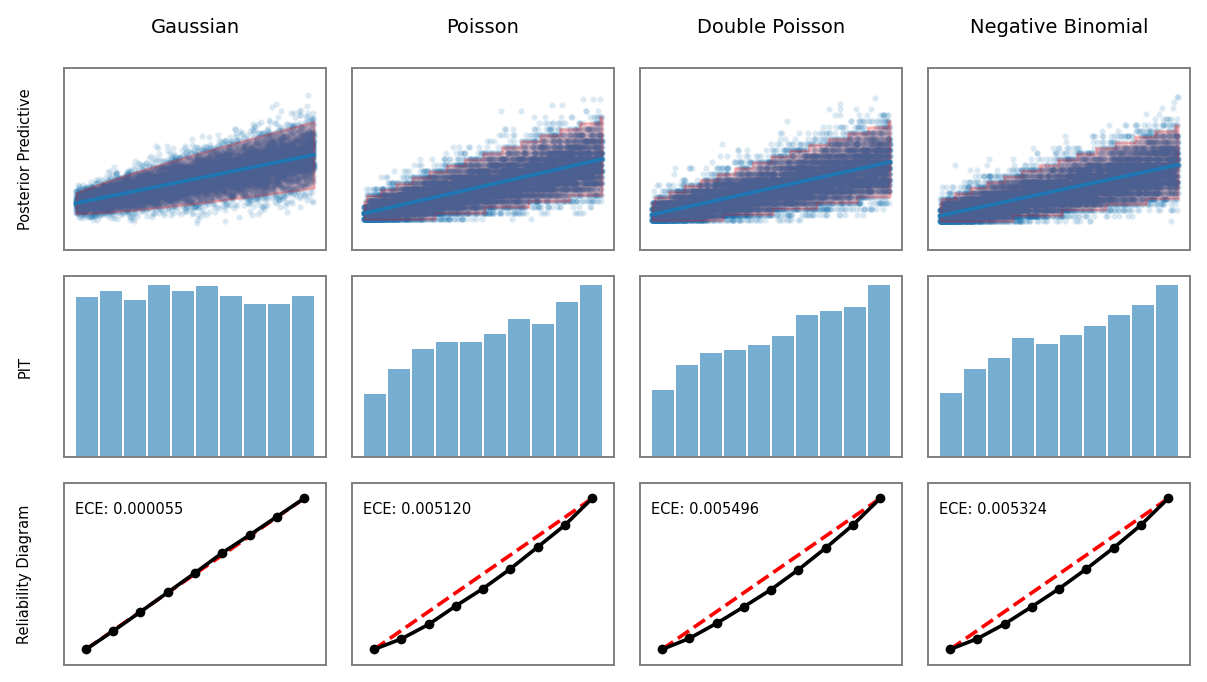

In [10]:
plt.rcParams['figure.dpi'] = 175
fig, axs = plt.subplots(3, 4, figsize=(7, 4))
title_size = 8
hist_alpha = 0.6
hist_rwidth = 0.9

plot_posterior_predictive(cont_x, gaussian_y, mu_hat, *gaussian_post_pred.ppf([[0.025], [0.975]]), ax=axs[0, 0], show=False)
axs[1, 0].hist(gaussian_post_pred.cdf(gaussian_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
plot_regression_calibration_curve_cdf(gaussian_y, gaussian_post_pred, ax=axs[2, 0], show=False)

plot_posterior_predictive(cont_x, poisson_y, lambda_hat, *poisson_post_pred.ppf([[0.025], [0.975]]), ax=axs[0, 1], show=False)
axs[1, 1].hist(poisson_post_pred.cdf(poisson_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
plot_regression_calibration_curve_cdf(poisson_y, poisson_post_pred, ax=axs[2, 1], show=False)

plot_posterior_predictive(cont_x, double_poisson_y, dpo_mu_hat, dpo_post_pred.ppf(0.025), dpo_post_pred.ppf(0.975), ax=axs[0, 2], show=False)
axs[1, 2].hist(dpo_post_pred.cdf(double_poisson_y.reshape(-1, 1).flatten()), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
plot_regression_calibration_curve_cdf(double_poisson_y.flatten(), dpo_post_pred, ax=axs[2, 2], show=False)

plot_posterior_predictive(cont_x, nbinom_y, nbinom_mu_hat, nbinom_post_pred.ppf(0.025), nbinom_post_pred.ppf(0.975), ax=axs[0, 3], show=False)
axs[1, 3].hist(nbinom_post_pred.cdf(nbinom_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
plot_regression_calibration_curve_cdf(nbinom_y, nbinom_post_pred, ax=axs[2, 3], show=False)

row_labels = ["Posterior Predictive", "PIT", "Reliability Diagram"]
for ax, row in zip(axs[:, 0], row_labels):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=6, ha='right', va='center', rotation=90)
    

col_labels = ["Gaussian", "Poisson", "Double Poisson", "Negative Binomial"]
for ax, col in zip(axs[0, :], col_labels):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=8, ha='center', va='baseline')
    
for ax in axs.ravel():
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

plt.tight_layout()
plt.show()

In [11]:
fig.tight_layout()
fig.savefig(fname="failure_of_pit.pdf", format="pdf")

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_11063/3088314453.py:1: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


## Continuous ECE

In [8]:
alpha = 1

In [9]:
compute_continuous_ece(gaussian_y, gaussian_post_pred, num_bins=50, weights="frequency", alpha=alpha), compute_continuous_ece(gaussian_y, bad_gaussian_post_pred, num_bins=50, weights="frequency", alpha=alpha) 

(0.0018860294696588335, 0.4766535149677359)

In [10]:
compute_continuous_ece(poisson_y, poisson_post_pred, num_bins=50, weights="frequency", alpha=alpha), compute_continuous_ece(poisson_y, bad_poisson_post_pred, num_bins=50, weights="frequency", alpha=alpha) 

(0.06448180336185973, 0.4721315377156267)

In [11]:
compute_continuous_ece(nbinom_y, nbinom_post_pred, num_bins=50, weights="frequency", alpha=alpha), compute_continuous_ece(nbinom_y, bad_nbinom_post_pred, num_bins=50, weights="frequency", alpha=alpha)

(0.06777419908508482, 0.4708823332513152)

In [12]:
compute_continuous_ece(double_poisson_y.flatten(), dpo_post_pred, num_bins=30, weights="frequency", alpha=alpha), compute_continuous_ece(double_poisson_y.flatten(), bad_dpo_post_pred, num_bins=30, weights="frequency", alpha=alpha)

(0.0675307306304294, 0.4654166348151225)

## Mode ECE

In [13]:
def compute_discrete_ece(
    targets: np.ndarray,
    probs: np.ndarray,
    k: int,
    bin_strategy: str = "adaptive",
    alpha: float = 1.0,
    num_bins: int = 30,
):
    """Given targets and predictions from a discrete probabilistic regression model (assumed to have support [0, inf)), compute the expected calibration error.

    Suppose we discretize [0, 1] into a set of m bins and assign each target {y_i | 1 <= i <= n} to a bin based on \sum_{j=1}^k P(\\hat{y_{ij}}),
    the cumulative probability of the model's top k predictions for that target. Define acc_k(B) to be the probability, within bin B, that y_i is
    in the top k predictions. Define conf_k(B) to be the average of \sum_{j=1}^k P(\\hat{y_{ij}}) within bin B. Then we have

        ECE = mean([ |acc_k(B) - conf_k(B))|^alpha for B in bins ])

    where alpha controls the severity of the penalty for the magnitude of a given probability residual.

    Bin boundaries can either be selected uniformly across [0, 1] or chosen such that each bin has the same number of targets.

    Args:
        targets (np.ndarray): The regression targets. Shape: (n,)
        probs (np.ndarray): The model's discrete probabilities for each target. Shape: (>=k, n).
        k (int): The number of most likely predictions to use in the calibration evaluation.
        bin_strategy (str, optional): Strategy for choosing bin boundaries. Must be either "uniform" or "adaptive". Defaults to "adaptive" (same # of targets in each bin).
        alpha (int, optional): Controls how severely we penalize the model for the magnitude of a probability residual. Defaults to 1 (error term is |acc(B) - conf(B)|).
        num_bins (int): The number of bins to use. Defaults to 30.

    Returns:
        float: The expected calibration error.
    """
    if probs.shape[0] < k:
        raise ValueError("Must provide probabilities with at least `k` entries for each target.")

    top_k_preds = np.argsort(probs, axis=0)[::-1][:k]
    top_k_probs = probs[top_k_preds, np.arange(len(targets))].sum(axis=0)
    if bin_strategy == "uniform":
        bin_boundaries = np.linspace(0, 1, num=num_bins)
        weights = None
    elif bin_strategy == "adaptive":
        bin_boundaries = pd.qcut(top_k_probs, num_bins, retbins=True, duplicates="drop")[1]
        actual_num_bins = len(bin_boundaries) - 1
        weights = np.ones(actual_num_bins) / actual_num_bins
    else:
        raise ValueError('Invalid bin strategy specified. Must be "uniform" or "adaptive".')

    # Handle if all probabilities are in the same bin.
    if len(bin_boundaries) == 1:
        return np.abs(np.mean([targets[i] in top_k_preds[:, i] for i in range(len(targets))]) - top_k_probs.mean()) ** alpha

    bin_boundaries[-1] += 1e-5  # Make rightmost bin boundary inclusive.
    mask_matrix = (bin_boundaries[:-1, None] <= top_k_probs) & (top_k_probs < bin_boundaries[1:, None])
    bin_counts = mask_matrix.sum(axis=1) + 1e-16
    bin_confidences = np.where(mask_matrix, top_k_probs, 0).sum(axis=1) / bin_counts

    if weights is None:
        weights = 1 / bin_counts

    bin_accuracies = np.where(mask_matrix, np.array([targets[i] in top_k_preds[:, i] for i in range(len(targets))]), 0).sum(axis=1) / bin_counts
    ece = np.dot(weights, np.abs(bin_accuracies - bin_confidences) ** alpha)
    return ece

In [14]:
calib_gauss_probs = norm.pdf(np.arange(2000).reshape(-1, 1), loc=mean, scale=np.sqrt(variance))
calib_gauss_probs = calib_gauss_probs / calib_gauss_probs.sum(axis=0)
uncalib_gauss_probs = norm.pdf(np.arange(2000).reshape(-1, 1), loc=bad_mean, scale=np.sqrt(bad_variance))
uncalib_gauss_probs = uncalib_gauss_probs / uncalib_gauss_probs.sum(axis=0)

compute_discrete_ece(double_poisson_y, calib_gauss_probs, k=1, alpha=alpha), compute_discrete_ece(double_poisson_y, uncalib_gauss_probs, k=1, alpha=alpha)

(0.02097277913520922, 0.10149046453884437)

In [15]:
probs = poisson_post_pred.pmf(np.arange(poisson_y.min(), poisson_y.max() + 1).reshape(-1, 1))
bad_probs = bad_poisson_post_pred.pmf(np.arange(poisson_y.min(), poisson_y.max() + 1).reshape(-1, 1))
compute_discrete_ece(poisson_y, probs, k=1, alpha=alpha), compute_discrete_ece(poisson_y, bad_probs, k=1, alpha=alpha)

(0.018709361513381265, 0.10207181073494652)

In [16]:
probs = nbinom_post_pred.pmf(np.arange(nbinom_y.min(), nbinom_y.max() + 1).reshape(-1, 1))
bad_probs = bad_nbinom_post_pred.pmf(np.arange(nbinom_y.min(), nbinom_y.max() + 1).reshape(-1, 1))
compute_discrete_ece(nbinom_y, probs, k=1, alpha=alpha), compute_discrete_ece(nbinom_y, bad_probs, k=1, alpha=alpha)

(0.016916202303403426, 0.10104846962342566)

In [17]:
probs = dpo_post_pred.pmf(np.arange(double_poisson_y.min(), double_poisson_y.max() + 1).reshape(-1, 1))
bad_probs = bad_dpo_post_pred.pmf(np.arange(double_poisson_y.min(), double_poisson_y.max() + 1).reshape(-1, 1))
compute_discrete_ece(double_poisson_y.flatten(), probs, k=1, alpha=alpha), compute_discrete_ece(double_poisson_y.flatten(), bad_probs, k=1, alpha=alpha)

(0.014209337241637103, 0.10127220873773977)

## Cluster ECE

In [18]:
from scipy.stats import entropy

def compute_cluster_ece(y: np.ndarray, probs: np.ndarray, cluster_labels: np.ndarray):
    """Given discrete labels and model probabilities, compute the calibration error using clustering.

    To estimate the calibration error, we cluster in `x` and approximate the empirical distribution within that cluster. We then see how
    close the model's predicted probabilities lie to the empirical distribution within the cluster.

    The `probs` array is assumed to specify the discrete probability that y takes on the values 0 through M (0 << M << infinity).

    Args:
        x (np.ndarray): Test inputs. Shape: (n, d).
        y (np.ndarray): Test outputs (should be counts). Shape: (n,)
        cluster_labels (np.ndarray): Cluster labels for test inputs.
        probs (np.ndarray): Model probabilities for y. Shape: (M + 1, n)
    """
    errs = []
    nums = []

    M = 2000

    for cluster_idx in np.unique(cluster_labels):
        in_cluster = cluster_labels == cluster_idx
        nums.append(in_cluster.sum())
        cluster_y = y[in_cluster]

        eps = 1e-5

        calibrated_probs_est = np.zeros(M + 1)
        values, counts = np.unique(cluster_y, return_counts=True)
        calibrated_probs_est[values] = counts / counts.sum()
        max_val = max(np.where(probs > 0)[0].max(), np.where(calibrated_probs_est > 0)[0].max())
        pred_count_probs = probs[:max_val, in_cluster]#.mean(axis=1)
        pred_count_probs = np.maximum(pred_count_probs, eps)
        calibrated_probs_est = np.maximum(calibrated_probs_est[:max_val], eps)

        #errs.append(entropy(pred_count_probs, calibrated_probs_est))
                
        e = []
        for p in pred_count_probs.T:
            e.append(entropy(p, calibrated_probs_est))
        errs.append(np.mean(e))

    nums = np.array(nums)
    nums = nums / nums.sum()
    return (nums * errs).sum()

In [19]:
# Fit a calibrated Gaussian to the double poisson targets (with the same mean and variance), then see what happens if we miscalibrate it.

calib_gauss_probs = norm.pdf(np.arange(2000).reshape(-1, 1), loc=mean, scale=np.sqrt(variance))
calib_gauss_probs = calib_gauss_probs / calib_gauss_probs.sum(axis=0)
uncalib_gauss_probs = norm.pdf(np.arange(2000).reshape(-1, 1), loc=bad_mean, scale=np.sqrt(bad_variance))
uncalib_gauss_probs = uncalib_gauss_probs / uncalib_gauss_probs.sum(axis=0)
cluster_labels = cont_x.round().astype(int)

compute_cluster_ece(double_poisson_y, calib_gauss_probs, cluster_labels), compute_cluster_ece(double_poisson_y, uncalib_gauss_probs, cluster_labels)

(0.030168502367156968, 6.0797637330880105)

In [20]:
calib_poiss_probs = poisson_post_pred.pmf(np.arange(2000).reshape(-1, 1))
uncalib_poiss_probs = bad_poisson_post_pred.pmf(np.arange(2000).reshape(-1, 1))
compute_cluster_ece(poisson_y, calib_poiss_probs, cluster_labels), compute_cluster_ece(poisson_y, uncalib_poiss_probs, cluster_labels)

(0.01697772510789374, 6.172763849180321)

In [21]:
calib_dpo_probs = dpo_post_pred.pmf(np.arange(2000).reshape(-1, 1))
uncalib_dpo_probs = bad_dpo_post_pred.pmf(np.arange(2000).reshape(-1, 1))
compute_cluster_ece(double_poisson_y, calib_dpo_probs, cluster_labels), compute_cluster_ece(double_poisson_y, uncalib_dpo_probs, cluster_labels)

(0.018532697965016075, 6.045281290772929)

In [22]:
calib_nbinom_probs = nbinom_post_pred.pmf(np.arange(2000).reshape(-1, 1))
uncalib_nbinom_probs = bad_nbinom_post_pred.pmf(np.arange(2000).reshape(-1, 1))
compute_cluster_ece(nbinom_y, calib_nbinom_probs, cluster_labels), compute_cluster_ece(nbinom_y, uncalib_nbinom_probs, cluster_labels)

(0.018726709937554927, 6.025810669737986)

## Sample ECE

In [23]:
def compute_sample_ece(targets: np.ndarray, samples: np.ndarray) -> float:
    """Compute the ECE by sampling from the predictive posterior.

    Args:
        targets (np.ndarray): The true regression targets (draws from the g.t. Y|X distribution). Shape: (n,)
        samples (np.ndarray): Samples from the posterior predictive distribution. Shape: (n, s).

    Returns:
        float: A metric describing the calibration of the posterior predictive distribution.
    """
    p = 2
    return np.sqrt(np.mean(np.abs(samples - targets.reshape(-1, 1))**p))

In [24]:
calib_gauss_samples = gaussian_post_pred.rvs((1000, num_samples))
miscalib_gauss_samples = bad_gaussian_post_pred.rvs((1000, num_samples))
compute_sample_ece(gaussian_y, calib_gauss_samples.T), compute_sample_ece(gaussian_y, miscalib_gauss_samples.T)

(3.314912020122327, 11.010492429772968)

In [25]:
calib_poisson_samples = poisson_post_pred.rvs((1000, num_samples))
miscalib_poisson_samples = bad_poisson_post_pred.rvs((1000, num_samples))
compute_sample_ece(double_poisson_y, calib_poisson_samples.T), compute_sample_ece(double_poisson_y, miscalib_poisson_samples.T)

(3.3546560330382604, 10.987135117945897)

In [26]:
calib_nbinom_samples = nbinom_post_pred.rvs((1000, num_samples))
miscalib_nbinom_samples = bad_nbinom_post_pred.rvs((1000, num_samples))
compute_sample_ece(double_poisson_y, calib_nbinom_samples.T), compute_sample_ece(double_poisson_y, miscalib_nbinom_samples.T)

(3.371199000355808, 10.99225604687227)

In [27]:
calib_dpo_samples = dpo_post_pred.rvs((1000, dpo_post_pred.dimension), verbose=True)
miscalib_dpo_samples = bad_dpo_post_pred.rvs((1000, dpo_post_pred.dimension), verbose=True)
compute_sample_ece(double_poisson_y, calib_dpo_samples.T), compute_sample_ece(double_poisson_y, miscalib_dpo_samples.T)

Sampling...: 100%|██████████| 1000/1000 [00:14<00:00, 68.27it/s]


(3.4319918414821444, 10.996222760566466)

### What if the counts are higher / the data has higher variance?

In [28]:
num_samples = 10000
cont_x = np.random.uniform(50, 150, size=num_samples)
mean = cont_x
variance = cont_x
gaussian_y = norm.rvs(loc=mean, scale=np.sqrt(variance))
poisson_y = poisson.rvs(mu=mean)
double_poisson_y = np.array([DoublePoisson(m, m/v).rvs(1) for m, v in zip(mean, variance)]).flatten()
eps = 1e-1
nbinom_y = nbinom.rvs(n=(mean**2 / (variance + eps - mean)).round(), p=(mean / (variance + eps)))

bad_mean = cont_x + 10
bad_variance = cont_x + 10

mu_hat = mean
gaussian_post_pred = norm(loc=mean, scale=np.sqrt(variance))
bad_gaussian_post_pred = norm(loc=bad_mean, scale=np.sqrt(bad_variance))

lambda_hat = mean
poisson_post_pred = poisson(mu=mean)
bad_poisson_post_pred = poisson(mu=bad_mean)

dpo_mu_hat = mean
dpo_post_pred = DoublePoisson(mean, mean/variance)
bad_dpo_post_pred = DoublePoisson(bad_mean, bad_mean / bad_variance)

nbinom_mu_hat = mean
nbinom_post_pred = nbinom(n=(mean**2 / (variance + eps - mean)).round(), p=(mean / (variance + eps)))
bad_nbinom_post_pred = nbinom(n=(bad_mean**2 / (bad_variance + eps - bad_mean)).round(), p=(bad_mean / (bad_variance + eps)))

In [29]:
calib_gauss_samples = gaussian_post_pred.rvs((1000, num_samples))
miscalib_gauss_samples = bad_gaussian_post_pred.rvs((1000, num_samples))
compute_sample_ece(double_poisson_y, calib_gauss_samples.T), compute_sample_ece(double_poisson_y, miscalib_gauss_samples.T)

(14.083168494056178, 17.538275086787134)

In [30]:
calib_poisson_samples = poisson_post_pred.rvs((1000, num_samples))
miscalib_poisson_samples = bad_poisson_post_pred.rvs((1000, num_samples))
compute_sample_ece(double_poisson_y, calib_poisson_samples.T), compute_sample_ece(double_poisson_y, miscalib_poisson_samples.T)

(14.08804181566764, 17.53108769871396)

In [31]:
calib_nbinom_samples = nbinom_post_pred.rvs((1000, num_samples))
miscalib_nbinom_samples = bad_nbinom_post_pred.rvs((1000, num_samples))
compute_sample_ece(double_poisson_y, calib_nbinom_samples.T), compute_sample_ece(double_poisson_y, miscalib_nbinom_samples.T)

(14.095348970493777, 17.534197871587967)

In [32]:
calib_dpo_samples = dpo_post_pred.rvs((1000, dpo_post_pred.dimension), verbose=True)
miscalib_dpo_samples = bad_dpo_post_pred.rvs((1000, dpo_post_pred.dimension), verbose=True)
compute_sample_ece(double_poisson_y, calib_dpo_samples.T), compute_sample_ece(double_poisson_y, miscalib_dpo_samples.T)

Sampling...: 100%|██████████| 1000/1000 [00:15<00:00, 65.05it/s]


(14.152850970740841, 17.88069079761741)

### How does this metric respond to overconfidence?

In [33]:
compute_sample_ece(double_poisson_y, DoublePoisson(mean, 100 * mean / variance).rvs((1000, 10000), True).T)

Sampling...: 100%|██████████| 1000/1000 [00:15<00:00, 64.48it/s]


9.994616590945348

### How does  this metric respond to underconfidence?

In [34]:
compute_sample_ece(double_poisson_y, DoublePoisson(mean, 0.5 * mean / variance).rvs((1000, 10000), True).T)

Sampling...: 100%|██████████| 1000/1000 [00:15<00:00, 64.55it/s]


17.587241475001132

### How does this metric respond to correct variance, incorrect mean?

In [35]:
compute_sample_ece(double_poisson_y, DoublePoisson(bad_mean, mean / variance).rvs((1000, 10000), True).T)

Sampling...: 100%|██████████| 1000/1000 [00:15<00:00, 64.66it/s]


17.65060338345406

### Does this metric favor sharp forecasts over equally calibrated, but less useful, broad forecasts?

Short answer: yes. For proof, see below

In [36]:
from scipy.stats import bernoulli

y = bernoulli(p=0.5).rvs(1000)
y_hat_sharp = np.array([[y_i if np.random.random() < 0.95 else np.random.randint(0, 1) for i in range(100)] for y_i in y])
y_hat_wide = bernoulli(p=0.5).rvs(1000, 100)

In [37]:
compute_sample_ece(y, y_hat_sharp), compute_sample_ece(y, y_hat_wide), compute_sample_ece(y, bernoulli.rvs(p=0.9, size=(1000, 100)))

(0.15313392831113554, 0.7071477921905717, 0.7238715355641496)

In [6]:
gaussian_probs = gaussian_post_pred.cdf(gaussian_y + 0.5) - gaussian_post_pred.cdf(gaussian_y - 0.5)
overconfident_gaussian_post_pred = norm(loc=cont_x, scale=0.01)
overconfident_gaussian_probs = overconfident_gaussian_post_pred.cdf(gaussian_y + 0.5) - overconfident_gaussian_post_pred.cdf(gaussian_y - 0.5)
poisson_probs = poisson_post_pred.pmf(poisson_y)
dpo_probs = dpo_post_pred.pmf(double_poisson_y)
overconfident_dpo_post_pred = DoublePoisson(mu=cont_x, phi=cont_x / 0.01)
overconfident_dpo_probs = overconfident_dpo_post_pred.pmf(double_poisson_y)
nbinom_probs = nbinom_post_pred.pmf(nbinom_y)

gaussian_probs.mean(), overconfident_gaussian_probs.mean(), poisson_probs.mean(), dpo_probs.mean(), overconfident_dpo_probs.mean(), nbinom_probs.mean()

(0.13344568628193296,
 0.1916593268860182,
 0.13803635876960468,
 0.13748509649872812,
 0.18111865996137597,
 0.13589444030573636)

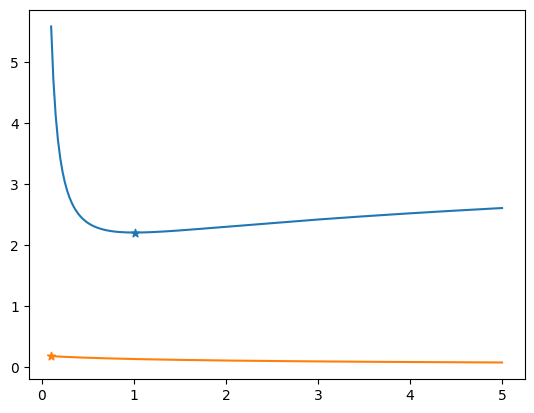

In [33]:
nlls = []
probs = []
multipliers = np.linspace(0.1, 5, num=200)
for m in multipliers:
    dist = norm(loc=cont_x, scale=np.sqrt(m*cont_x))
    nlls.append(-dist.logpdf(gaussian_y).mean())
    probs.append(dist.pdf(gaussian_y).mean())

plt.plot(multipliers, nlls)
plt.plot(multipliers, probs)
plt.scatter(multipliers[np.argmin(nlls)], nlls[np.argmin(nlls)], marker='*')
plt.scatter(multipliers[np.argmax(probs)], probs[np.argmax(probs)], marker='*')

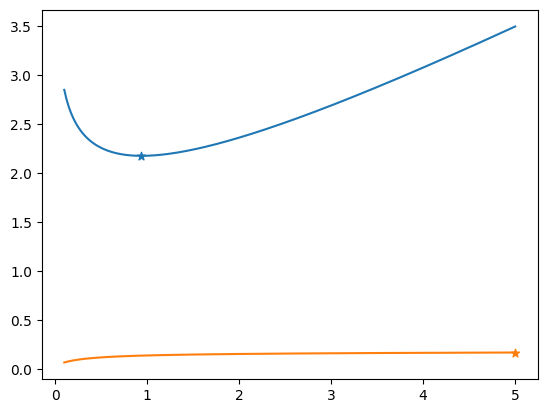

In [31]:
nlls = []
probs = []
phi_vals = np.linspace(0.1, 5, num=200)
for phi in phi_vals:
    dist = DoublePoisson(cont_x, phi)
    nlls.append(-dist._logpmf(double_poisson_y).mean())
    probs.append(dist._pmf(double_poisson_y).mean())

plt.plot(phi_vals, nlls)
plt.plot(phi_vals, probs)
plt.scatter(phi_vals[np.argmin(nlls)], nlls[np.argmin(nlls)], marker='*')
plt.scatter(phi_vals[np.argmax(probs)], probs[np.argmax(probs)], marker='*')

## Original Code

In [38]:
def plot_regression_calibration_curve_interval(
    y_true: np.ndarray,
    posterior_predictive: rv_continuous,
    num_bins: int = 9,
    ax: plt.Axes | None = None,
    show: bool = True,
):
    """Given targets and a probabilistic regression model (represented as a continuous random variable over the targets), plot a calibration curve.

    Args:
        y_true (ndarray, (n,)): The true values of the regression targets.
        posterior_predictive (rv_continuous): Random variable representing the posterior predictive distribution over the targets.
        num_bins (int): Specifies how many probability thresholds to use for checking CDF calibration. This
                        corresponds to how many points will be plotted to form the calibration curve.
        ax (plt.Axes | None): The axis to plot on (if provided). If None is passed in, an axis is created.
        show (bool): Specifies whether/not to display the resultant plot.
    """
    epsilon = 1e-4
    p_vals = np.linspace(0 + epsilon, 1 - epsilon, num=num_bins).reshape(-1, 1)
    expected_pct_in_interval = p_vals
    actual_pct_in_interval = []
    for p in p_vals:
        tail = (1 - p) / 2
        lower, upper = posterior_predictive.ppf(tail), posterior_predictive.ppf(1 - tail)
        in_interval = (y_true >= lower) & (y_true <= upper)
        actual_pct_in_interval.append(in_interval.mean())

    ax = plt.subplots(1, 1)[1] if ax is None else ax
    ax.set_title("Calibration Curve")
    ax.set_xlabel("Expected Confidence Level")
    ax.set_ylabel("Observed Confidence Level")
    ax.plot(
        expected_pct_in_interval,
        expected_pct_in_interval,
        linestyle="--",
        color="red",
        label="Perfectly calibrated",
    )
    ax.plot(
        expected_pct_in_interval,
        actual_pct_in_interval,
        marker="o",
        linestyle="-",
        color="black",
        label="Model",
    )
    ax.legend()
    plt.tight_layout()

    if show:
        plt.show()

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_98519/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_98519/1914299827.py:16: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


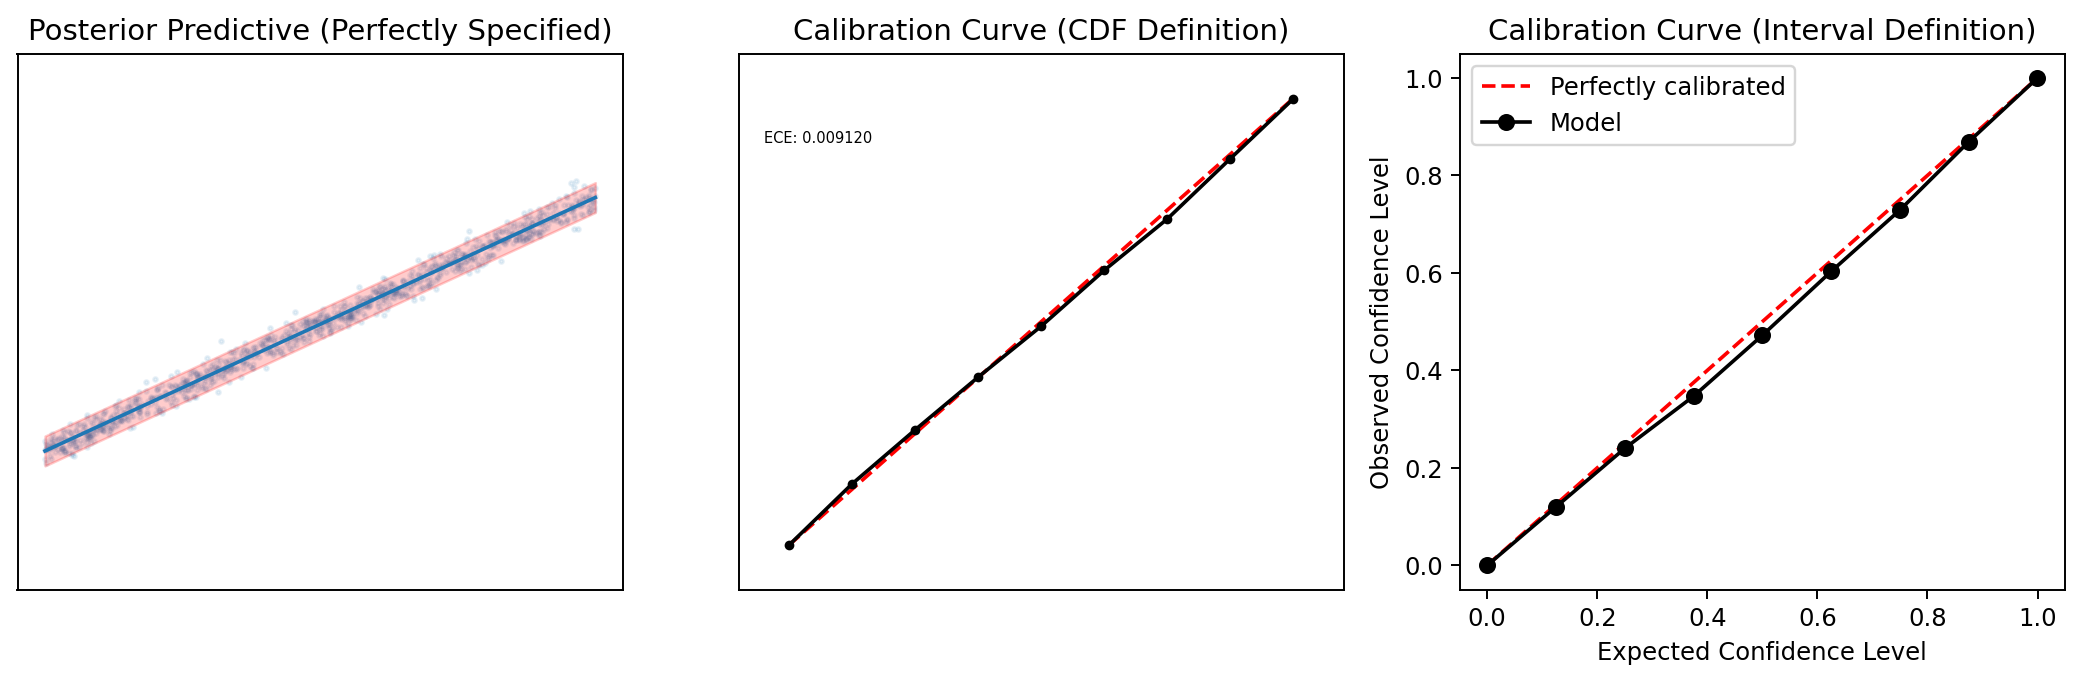

In [39]:
x = np.random.uniform(1e-4, 10, size=1000)
y = norm.rvs(loc=x, scale=0.3)

# Perfectly specified model.
mu_hat = x
sigma_hat = 0.3
posterior_predictive = norm(loc=mu_hat, scale=sigma_hat)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, mu_hat, *posterior_predictive.ppf([[0.025], [0.975]]), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y, posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y, posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
fig.tight_layout()

plt.show()

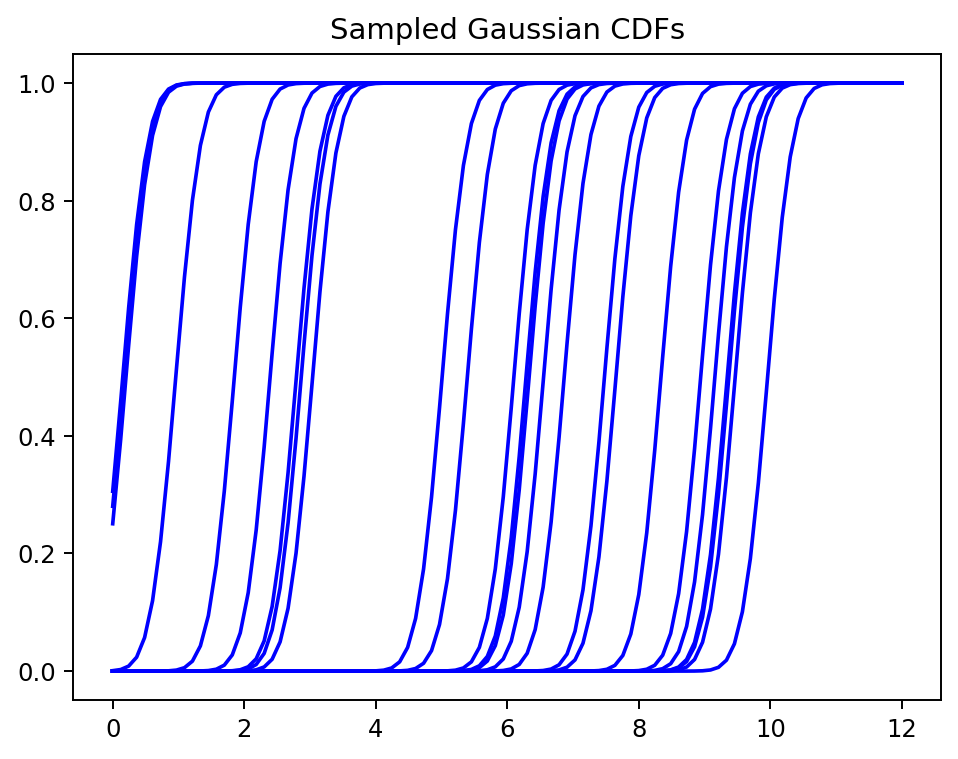

In [40]:
plt.title("Sampled Gaussian CDFs")
plt.plot(np.linspace(0, 12, num=100), posterior_predictive.cdf(np.stack([np.linspace(0, 12, num=100) for _ in range(y.size)], axis=1))[:, :25], c='blue')
plt.show()

(0.0, 1.0)

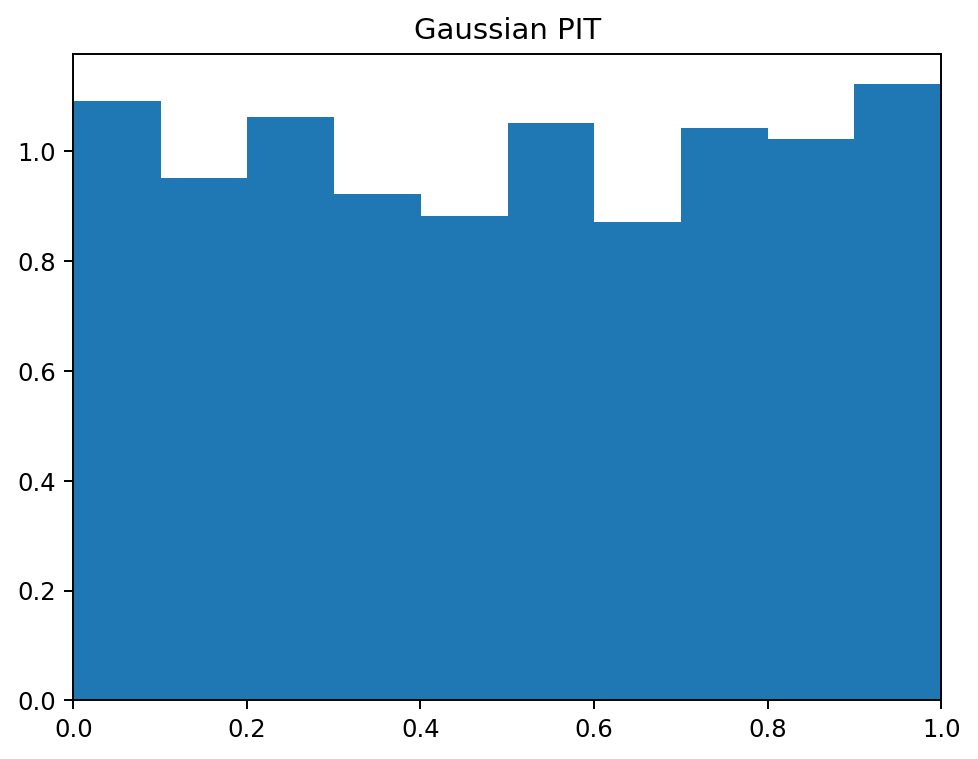

In [41]:
plt.title("Gaussian PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_98519/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_98519/1057251793.py:16: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


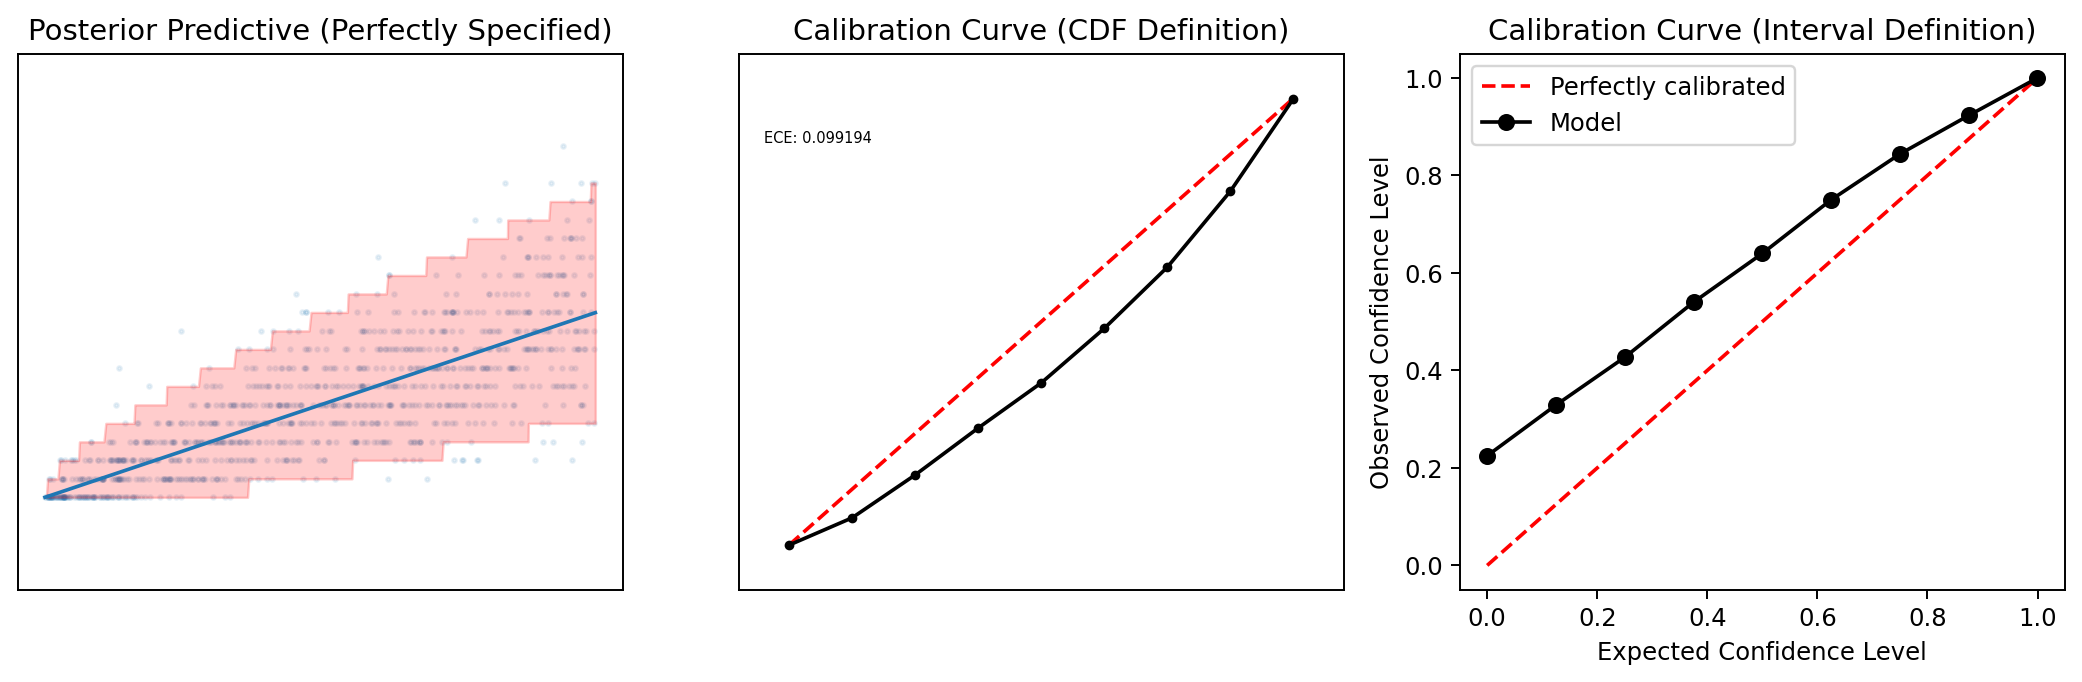

In [42]:
x = np.random.uniform(1e-4, 10, size=1000)
y = poisson.rvs(mu=x)

# Perfectly specified model.
lambda_hat = x
posterior_predictive = poisson(mu=lambda_hat)
preds = np.floor(lambda_hat)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, lambda_hat, *posterior_predictive.ppf([[0.025], [0.975]]), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y, posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y, posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
fig.tight_layout()
plt.show()

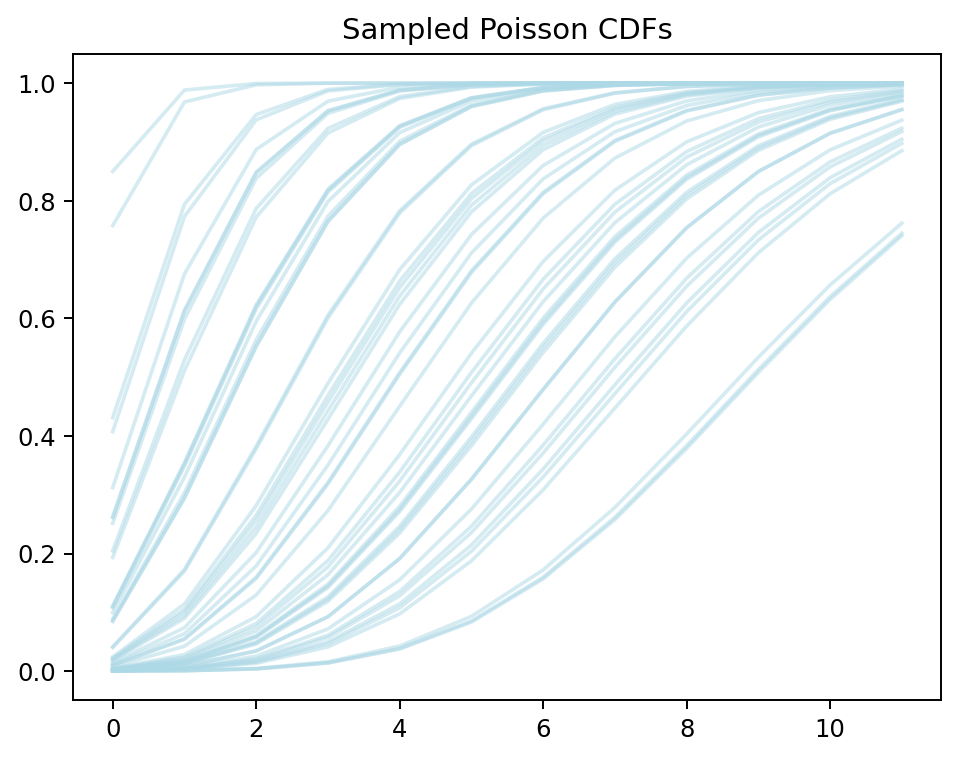

In [43]:
plt.title("Sampled Poisson CDFs")
plt.plot(np.arange(12), posterior_predictive.cdf(np.stack([np.arange(12) for _ in range(y.size)], axis=1))[:, :50], c='lightblue', alpha=0.5)
plt.show()

(0.0, 1.0)

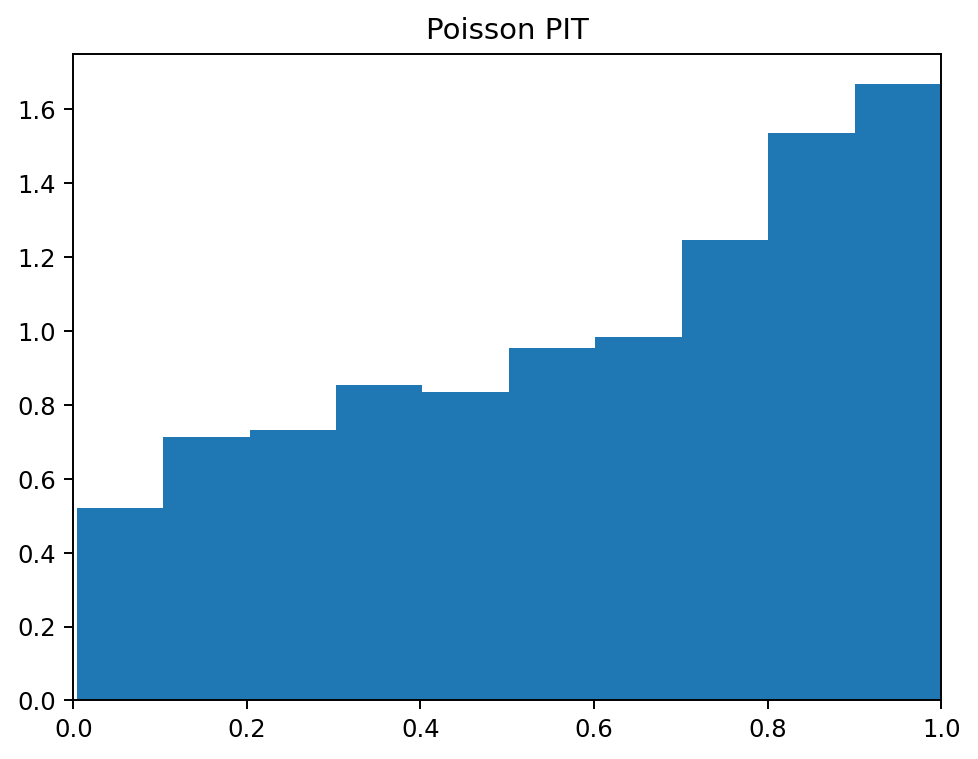

In [44]:
plt.title("Poisson PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

In [45]:
conf

NameError: name 'conf' is not defined

In [ ]:
acc

array([0.20588235, 0.18181818, 0.21212121, 0.20588235, 0.12121212,
       0.21212121, 0.14705882, 0.15151515, 0.03030303, 0.14705882,
       0.20588235, 0.21212121, 0.06060606, 0.17647059, 0.21212121,
       0.15151515, 0.23529412, 0.06060606, 0.21212121, 0.29411765,
       0.23529412, 0.21212121, 0.21212121, 0.23529412, 0.24242424,
       0.3030303 , 0.29411765, 0.36363636, 0.66666667, 0.91176471])

In [ ]:
print(compute_discrete_ece(y, preds, posterior_predictive.pmf(preds), alpha=2))

0.0035745163110305024


/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


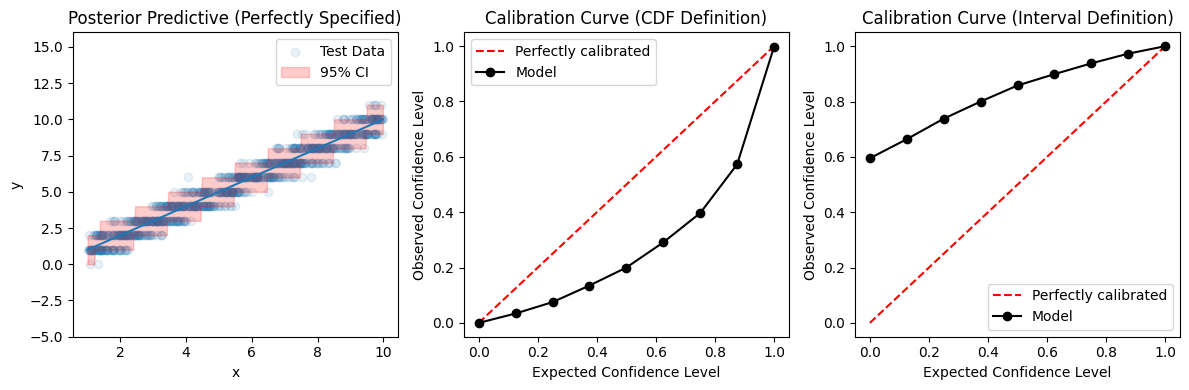

In [ ]:
x = np.random.uniform(1, 10, size=1000)
y = np.array([DoublePoisson(x_i, 3*x_i).rvs(1) for x_i in x]).astype(int)

mu_hat = x
phi_hat = 3*x
posterior_predictive = DoublePoisson(mu_hat, phi_hat)
preds = posterior_predictive.pmf_vals.argmax(axis=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, mu_hat, posterior_predictive.ppf(0.025), posterior_predictive.ppf(0.975), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y.flatten(), posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y.flatten(), posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
plt.show()

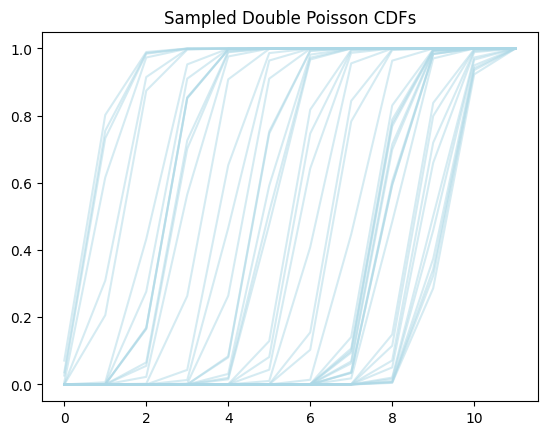

In [ ]:
plt.title("Sampled Double Poisson CDFs")
plt.plot(np.arange(12), posterior_predictive.cdf(np.stack([np.arange(12) for _ in range(y.size)], axis=1))[:, :50], c='lightblue', alpha=0.5)
plt.show()

(0.0, 1.0)

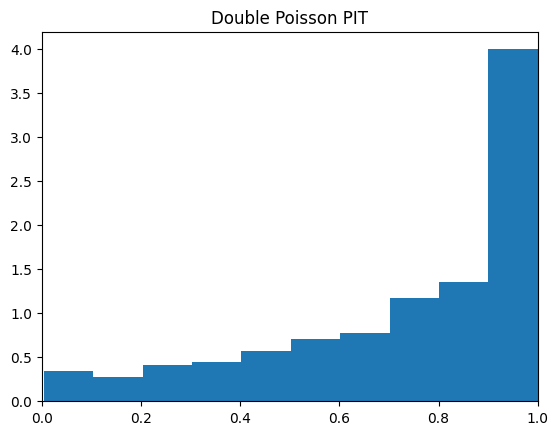

In [ ]:
plt.title("Double Poisson PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

In [ ]:
print(compute_discrete_ece(y.flatten(), preds, posterior_predictive.pmf(preds), alpha=2))

0.006892110700116499


/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


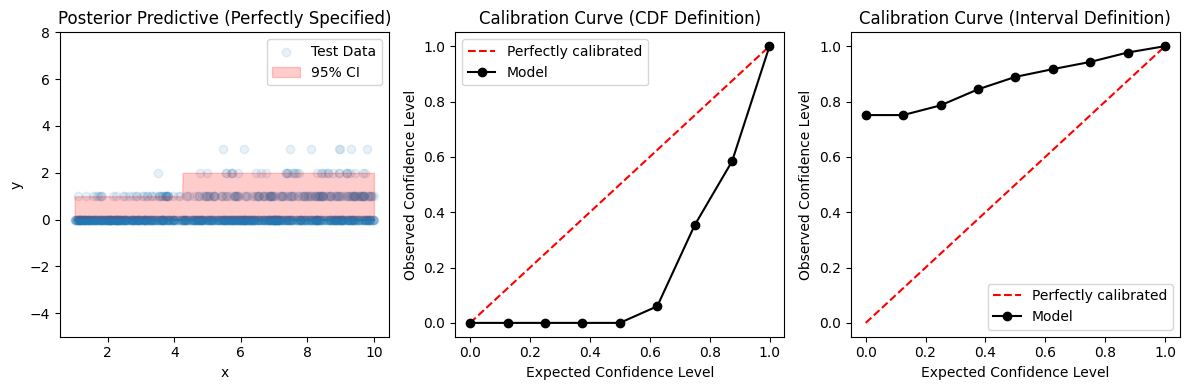

In [ ]:
x = np.random.uniform(1, 10, size=1000)
y = nbinom.rvs(n=x, p=0.95)

n_hat = x
p_hat = 0.95
posterior_predictive = nbinom(n=n_hat, p=p_hat)
preds = np.floor((n_hat - 1) * (1 - p_hat) / p_hat)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, preds, posterior_predictive.ppf(0.025), posterior_predictive.ppf(0.975), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y, posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y, posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
plt.show()

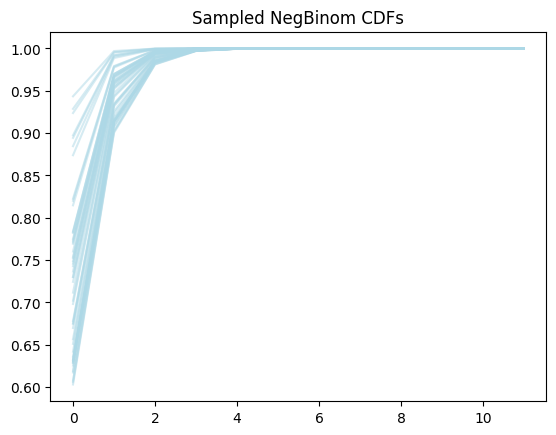

In [ ]:
plt.title("Sampled NegBinom CDFs")
plt.plot(np.arange(12), posterior_predictive.cdf(np.stack([np.arange(12) for _ in range(y.size)], axis=1))[:, :50], c='lightblue', alpha=0.5)
plt.show()

(0.0, 1.0)

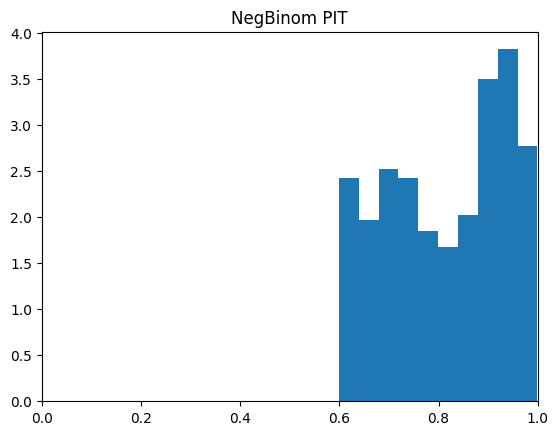

In [ ]:
plt.title("NegBinom PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

In [ ]:
print(compute_discrete_ece(y.flatten(), preds, posterior_predictive.pmf(preds), alpha=2))

0.006797045275855211
